# Вариант 2
## Проект e-learning
Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) **(7 баллов)**.

2. Выяви самый сложный и самый простой экзамен: 
найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью. **(10 баллов)**

3. По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом). **(7 баллов)**

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. 
А также предметы с самым большим оттоком (ТОП-3). **(8 баллов)**

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой 
завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  **(15 баллов)** 

6. Часто для качественного анализа аудитории используют подходы, 
основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, 
чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: 
R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. 
Подробно опиши, как ты создавала кластеры. 
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. **(23 баллов)**

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. 
Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентефикатора курса.

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
# !pip install pandas_profiling --upgrade
# from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# считывание данных с помощью api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = ['https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ',
              'https://disk.yandex.ru/d/jmJxR8yhwCXlaw',
              'https://disk.yandex.ru/d/DYd4M5b_8RETsA',
              'https://disk.yandex.ru/d/lqHnH8NOZ458iw']

assessments = pd.DataFrame()
courses = pd.DataFrame()
studentAssessment = pd.DataFrame()
studentRegistration = pd.DataFrame()
df = ['assessments', 'courses', 'studentAssessment', 'studentRegistration']

for i, j in zip(public_key, df):
    final_url = base_url + urlencode(dict(public_key=i)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    locals()[j] = pd.read_csv(download_url)

## Посмотрим на данные подробнее, проведем предварительный анализ данных.

**assessments.csv** — этот файл содержит информацию об оценках в тесте.

Обычно каждый предмет в семестре включает ряд тестов с оценками, 
за которыми следует заключительный экзаменационный тест (экзамен).

`code_module` — идентификационный код предмета.

`code_presentation` — семестр (Идентификационный код).

`id_assessment` — тест (Идентификационный номер ассессмента).

`assessment_type` — тип теста. 
Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

`date` — информация об окончательной дате сдачи теста. 
Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

`weight` — вес теста в % в оценке за курс. 
Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [3]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [4]:
assessments.shape[0] - assessments.drop_duplicates().shape[0]  # дубликатов нет

0

Посмотрим на описательные статистики.

In [5]:
assessments.describe()

,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


In [6]:
assessments.describe(include='object')

,code_module,code_presentation,assessment_type
count,206,206,206
unique,7,4,3
top,FFF,2014J,TMA
freq,52,57,106


In [7]:
assessments.groupby(['code_presentation', 'code_module', 'assessment_type']).agg({'weight': 'sum'})

weight
code_presentation code_module assessment_type        
2013B             BBB         CMA                 5.0
                              Exam              100.0
                              TMA                95.0
                  DDD         CMA                25.0
                              Exam              100.0
                              TMA                75.0
                  FFF         CMA                 0.0
                              Exam              100.0
                              TMA               100.0
2013J             AAA         Exam              100.0
                              TMA               100.0
                  BBB         CMA                 5.0
                              Exam              100.0
                              TMA                95.0
                  DDD         Exam              100.0
                              TMA               100.0
                  EEE         Exam              100.0
                              TMA               100.0
                  FFF         CMA                 0.0
                              Exam              100.0
                              TMA               100.0
                  GGG         CMA                 0.0
                              Exam              100.0
                              TMA                 0.0
2014B             BBB         CMA                 5.0
                              Exam              100.0
                              TMA                95.0
                  CCC         CMA                25.0
                              Exam              200.0
                              TMA                75.0
                  DDD         Exam              100.0
                              TMA               100.0
                  EEE         Exam              100.0
                              TMA               100.0
                  FFF         CMA                 0.0
                              Exam              100.0
                              TMA               100.0
                  GGG         CMA                 0.0
                              Exam              100.0
                              TMA                 0.0
2014J             AAA         Exam              100.0
                              TMA               100.0
                  BBB         Exam              100.0
                              TMA               100.0
                  CCC         CMA                25.0
                              Exam              200.0
                              TMA                75.0
                  DDD         Exam              100.0
                              TMA               100.0
                  EEE         Exam              100.0
                              TMA               100.0
                  FFF         CMA                 0.0
                              Exam              100.0
                              TMA               100.0
                  GGG         CMA                 0.0
                              Exam              100.0
                              TMA                 0.0

В таблице сверху представлена принадлежность предметов к конкретным семестрам и типы оценивания этих предметов.

Видим, что *Exam* есть по каждому предмету в каждом семестре, т.е. экзаменом оканчивается каждый предмет в каждом семестре.

Так как, согласно описанию *df*, тип оценивания *Exam* - это экзамен *по курсу*, то **<u>курсом при дальнейшем исследовании будем считать каждый предмет в каждом семестре</u>** (в каждом семестре - потому что в каждом семестре у них разный id_assessment и в каждом семестре предмет оканчивается экзаменом).

То есть, всего у нас 4 семестра и 22 курса: 
- в 2013B 3 курса (BBB, DDD, FFF)
- в 2013J 6 курсов (AAA, BBB, DDD, EEE, FFF, GGG)
- в 2014B 6 курсов (BBB, CCC, DDD, EEE, FFF, GGG) 
- в 2014J 7 курсов (AAA, BBB, CCC, DDD, EEE, FFF, GGG)

По весу есть нестыковки: *weight = 200* в предмете *CCC* объясняется наличием двух экзаменов в семестре (разных по *id_assessment*). Это аномалия, потому что, по условию, каждый предмет заканчивается одним экзаменом. Рассмотрев данные по предмету CCC (я не стала вписывать в ноутбук излишне громоздкие датафреймы с самим анализом этого - только выводы), можно увидеть, что студенты сдавали один экзамен по этому предмету (у них присутствует оценка в score и дата сдачи в date_submitted) и успешно завершали курс, значит, информация о двух экзаменах по CCC - ошибка и экзамен на самом деле был один. 

Также, по предмету GGG вес CMA + TMA *weight = 0*, что тоже не совпадает с условиями задачи (CMA + TMA должно быть 100). Проверив эту информацию по конкретным студентам, обнаружили, что у студентов присутствуют оценки в score по данным типам оценивания, а значит, вероятно, информация о нулевом весе в предмете GGG тоже является ошибочной. Может быть, забыли внести эти данные.

In [8]:
assessments.info()  # в колонке date 11 пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [9]:
assessments.query('date.isna()')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Пропуски в date - по экзаменам за предметы AAA, BBB, CCC, DDD

Посмотрим количество студентов, сдающих экзамен по предметам AAA и BBB

In [10]:
(assessments.merge(studentAssessment, on='id_assessment')) \
    .merge(studentRegistration, on=['id_student', 'code_module', 'code_presentation']) \
    .query("assessment_type == 'Exam'").query("code_module == 'AAA' or code_module == 'BBB'") \
    .id_student.count()

0

Посмотрим, завершили ли студенты курс по AAA и BBB - если завершили, то будет выведен массив NaN-ов

In [11]:
(assessments.merge(studentAssessment, on='id_assessment')) \
    .merge(studentRegistration, on=['id_student', 'code_module', 'code_presentation']) \
    .query("date_unregistration.isna()").query("code_module == 'AAA' or code_module == 'BBB'") \
    .date_unregistration.unique()

array([nan])

Теперь посмотрим на экзамены по курсам CCC и DDD c date = NaN

In [12]:
(assessments.merge(studentAssessment, on='id_assessment')) \
    .merge(studentRegistration, on=['id_student', 'code_module', 'code_presentation']) \
    .query("date.isna() & assessment_type == 'Exam'") \
    .groupby(['code_presentation', 'code_module']) \
    .agg({'score': 'nunique', 'date_unregistration': 'unique'})

score date_unregistration
code_presentation code_module                           
2014B             CCC             46               [nan]
2014J             CCC             46               [nan]
                  DDD             40               [nan]

**Вывод:**

Ни один студент не регистрировался для сдачи и не сдавал *экзамен* по курсам AAA или BBB, оценки за эти экзамены также отсутствуют. При этом, у этих студентов стоят оценки по TMA и CMA и они завершили курс по этим предметам. Можно предположить, что экзамен по этим курсам не проводился, а решение о завершении курса принималось на основании основании оценок по *TMA* и *CMA*.

Студенты сдавали экзамен по курсам CCC и DDD, у них стоят за экзамен оценки в score и они завершили курсы CCC и DDD. Скорее всего, экзамен по CCC и DDD всё же проводился, а отсутствие даты экзамена связано с ошибкой в данных.

**courses.csv** — файл содержит список предметов по семестрам.

`code_module` — предмет (идентификационный код).

`code_presentation` — семестр (идентификационный код).

`module_presentation_length` — продолжительность семестра в днях.

In [13]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [14]:
courses.shape[0] - courses.drop_duplicates().shape[0]  # дубликатов нет

0

Посмотрим на описательные статистики.

In [15]:
courses.describe()

,module_presentation_length
count,22.000000
mean,255.545455
std,13.654677
min,234.000000
25%,241.000000
50%,261.500000
75%,268.000000
max,269.000000


In [16]:
courses.describe(include='object')

,code_module,code_presentation
count,22,22
unique,7,4
top,BBB,2014J
freq,4,7


In [17]:
courses.info()  # в этом df всё норм

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


Очень необычная продолжительность семестра - 8-9 месяцев! Обычно семестр подразумевает продолжительность 4 месяца и на 5 месяц проводится сессия.

Объединим *assessments* с *courses*, таким образом в общем *df* появится колонка с продолжительностью семестра, а колонку *weight* уберем, так как мы ее уже проверили и в дальнейшем она нам не пригодится. Результат перезапишем в assessments.

In [18]:
assessments = assessments.merge(courses, on=['code_module', 'code_presentation']).drop(columns='weight')

**studentAssessment.csv** — этот файл содержит результаты тестов студентов. 
Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

`id_assessment` — тест (идентификационный номер).

`id_student` — идентификационный номер студента.

`date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

`is_banked` — факт перезачета теста с прошлого семестра 
(иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

`score` — оценка учащегося в этом тесте. 
Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [19]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [20]:
studentAssessment.shape[0] - studentAssessment.drop_duplicates().shape[0]  # дубликатов нет

0

Посмотрим на описательные статистики.

In [21]:
studentAssessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


In [22]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [23]:
studentAssessment.isna().sum()  # 173 пропуска в колонке score

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

По условию, если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
Пропуски в score говорят о том, что работа была отправлена студентом, но не проверена (либо проверена, но результат не внесен в таблицу). Вероятно, это ошибка в данных.

P.S. Я это посмотрела, но считаю лишним добавлять в ноутбук саму проверку: все пропуски в score принадлежат assessment_type = TMA (оценка преподавателя). При этом у одного студента is_banked = 1 (перезачет после академа) - оценка точно должна была быть. То есть это точно ошибка в данных - преподаватель забыл внести результат в таблицу.

**studentRegistration.csv** — этот файл содержит информацию о времени, 
когда студент зарегистрировался для прохождения курса в семестре.

`code_module` — предмет (идентификационный код).

`code_presentation` — семестр (идентификационный код)

`id_student` — идентификационный номер студента.

`date_registration` — дата регистрации студента. 
Это количество дней, измеренное от начала семестра 
(например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

`date_unregistration` — дата отмены регистрации студента с предмета. 
У студентов, окончивших курс, это поле остается пустым.

In [24]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [25]:
studentRegistration.shape[0] - studentRegistration.drop_duplicates().shape[0]  # дубликатов нет

0

Посмотрим на описательные статистики.

In [26]:
studentRegistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


In [27]:
studentRegistration.describe(include='object')

,code_module,code_presentation
count,32593,32593
unique,7,4
top,BBB,2014J
freq,7909,11260


In [28]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [29]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

45 пропусков в date_registration (о 43 студентах), NaN в date_unregistration - это норма

Рассмотрим пропуски в date_registration подробнее.

Выведем студентов с пропусками и по date_registration, и по date_unregistration (якобы завершивших курс).

In [30]:
(studentRegistration.query("date_registration.isna()")).merge(studentAssessment, on='id_student', how='left') \
    .query("date_unregistration.isna()")

,code_module,code_presentation,id_student,date_registration,date_unregistration,id_assessment,date_submitted,is_banked,score
0,BBB,2013B,630346,NaN,NaN,NaN,NaN,NaN,NaN
38,CCC,2014J,1777834,NaN,NaN,NaN,NaN,NaN,NaN
46,DDD,2013B,2707979,NaN,NaN,NaN,NaN,NaN,NaN
47,DDD,2013B,2710343,NaN,NaN,NaN,NaN,NaN,NaN
70,DDD,2014B,2710343,NaN,NaN,NaN,NaN,NaN,NaN
78,FFF,2013B,2102658,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что информация об этих 5 студентах (в 6 записях) отсуствует в studentAssessment (они не сдавали никаких тестов). Вероятно, эти студенты случайно попали в датафрейм studentRegistration и пропуск date_unregistration говорит не об успешном завершении ими курса, а об отсутсвии каких-либо данных о них. По сути, мы не знаем о них никакой информации, кроме их id и курса обучения.

Выведем студентов, отменивших запись на курс с пропусками date_registration, но имеющих оценку в score

In [31]:
not_complete_course = (studentRegistration.query("date_registration.isna()").query("date_unregistration.notna()")) \
    .merge(studentAssessment, on='id_student', how='left') \
    .groupby('id_student', as_index=False) \
    .agg({'score': 'count', 'is_banked': 'sum'}) \
    .rename(columns={'score': 'count_of_score', 'is_banked': 'count_of_transfer'}) \
    .query("count_of_score != 0")
not_complete_course

,id_student,count_of_score,count_of_transfer
2,128965,6,0.0
6,394791,9,0.0
9,535460,2,0.0
10,544271,12,0.0
11,550142,16,4.0
13,575419,4,0.0
15,591648,1,0.0
19,604632,1,0.0
35,2681277,2,0.0


Из этих оставшихся 39 пропусков, 30 пропусков соответствуют студентам, которые не сдавали ни одного теста - количество в оценок в score равно 0. То есть, вероятно, они записались на курс (но кто-то забыл указать об этом информацию в date_registration), но отменили свою запись до сдачи каких-либо тестов.

Еще у 9 студентов присутствуют оценки в score. Из них 7 студентов сдали тесты выше порога и отменили регистрацию на курс после сдачи тестов. Наверное, им оказался больше не актуален данный курс.

Один студент (id 575419) сдал тест ниже порогового значения, при этом отменил запись на курс еще до начала семестра - однозначно, это ошибка данных.

И еще об одном студенте (id 550142) присутствует много записей, среди них как оценки ниже порога, так и выше него. Также, ему перезачитывали 4 теста (которые соответствуют семестру 2013J - видимо он уходил в академ в этом семестре).

Визуализируем количество тестов в кажом семестре: 

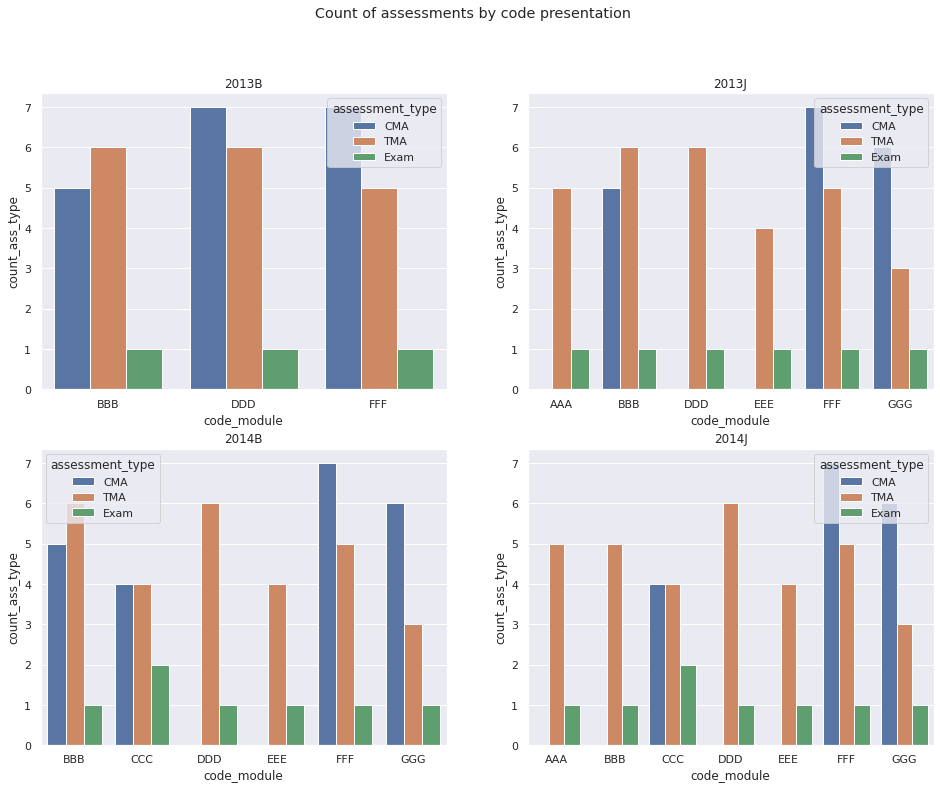

In [59]:
forplot_1 = assessments.query("code_presentation == '2013B'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(count_ass_type=('assessment_type', 'count'))

forplot_2 = assessments.query("code_presentation == '2013J'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(count_ass_type=('assessment_type', 'count'))

forplot_3 = assessments.query("code_presentation == '2014B'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(count_ass_type=('assessment_type', 'count'))

forplot_4 = assessments.query("code_presentation == '2014J'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(count_ass_type=('assessment_type', 'count'))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Count of assessments by code presentation')
axes[0, 0].set_title('2013B')
axes[0, 1].set_title('2013J')
axes[1, 0].set_title('2014B')
axes[1, 1].set_title('2014J')
sns.set_theme()
sns.barplot(ax=axes[0, 0], data=forplot_1, x='code_module', y='count_ass_type', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[0, 1], data=forplot_2, x='code_module', y='count_ass_type', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[1, 0], data=forplot_3, x='code_module', y='count_ass_type', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[1, 1], data=forplot_4, x='code_module', y='count_ass_type', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])

Посмотрим на количество сдающих экзамены студентов в кажом семестре.

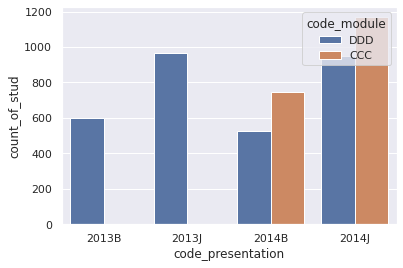

In [33]:
stud_exams = assessments.merge(studentAssessment)

forplot_9 = stud_exams.query("assessment_type == 'Exam'") \
    .groupby(['code_presentation', 'code_module'], as_index=False) \
    .agg(count_of_stud=('id_student', 'nunique'))

sns.barplot(data=forplot_9, x='code_presentation', y='count_of_stud', hue='code_module')

Студенты сдавали экзамены только по предметам DDD и CCC. Наибольшее количество студентов, сдающих экзамены, было зафиксировано в семесте 2014J - чуть больше 2000 человек.

Визуализируем среднюю оценку по разным типам оценивания в предметах каждого семестра.

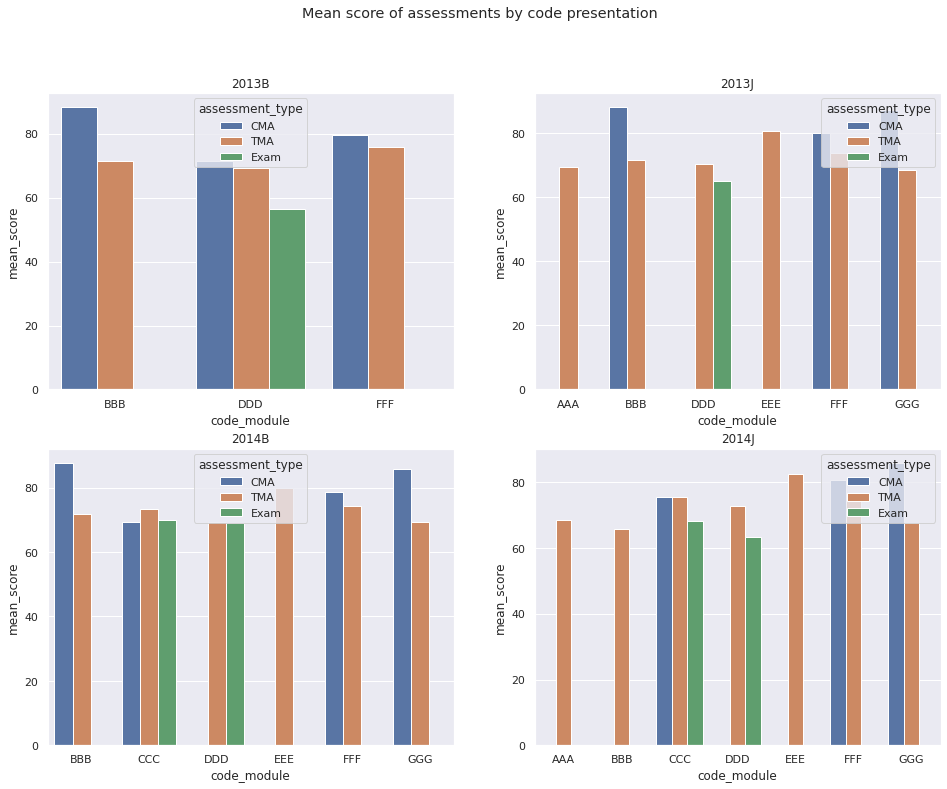

In [34]:
forplot_5 = stud_exams.query("code_presentation == '2013B'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(mean_score=('score', 'mean'))

forplot_6 = stud_exams.query("code_presentation == '2013J'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(mean_score=('score', 'mean'))

forplot_7 = stud_exams.query("code_presentation == '2014B'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(mean_score=('score', 'mean'))

forplot_8 = stud_exams.query("code_presentation == '2014J'") \
    .groupby(['code_module', 'assessment_type'], as_index=False) \
    .agg(mean_score=('score', 'mean'))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mean score of assessments by code presentation')
axes[0, 0].set_title('2013B')
axes[0, 1].set_title('2013J')
axes[1, 0].set_title('2014B')
axes[1, 1].set_title('2014J')
sns.set_theme()
sns.barplot(ax=axes[0, 0], data=forplot_5, x='code_module', y='mean_score', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[0, 1], data=forplot_6, x='code_module', y='mean_score', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[1, 0], data=forplot_7, x='code_module', y='mean_score', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])
sns.barplot(ax=axes[1, 1], data=forplot_8, x='code_module', y='mean_score', 
            hue='assessment_type', hue_order=['CMA', 'TMA', 'Exam'])

Самый низкий средний балл за экзамен по курсу DDD в семестре 2013B - менее 60 баллов. Сдавать этот экзамен студентам было сложнее всего. А самый высокий - за экзамен по курсу ССС в семестре 2014B - 70 баллов. Этот экзамен дался студентам легче всего.

## Приступим к заданиям.

### Задание 1
Cколько студентов успешно сдали только один курс?

In [35]:
# этот df пригодится и в следующих заданиях
df_1 = studentAssessment.merge(assessments, how='inner', on='id_assessment')

stud_pass_one = df_1.query("score >= 40 & assessment_type == 'Exam'") \
    .groupby('id_student', as_index=False).agg({'id_assessment': 'count'}) \
    .query('id_assessment == 1') \
    .id_student.count()

print(f'Количество студентов, успешно сдавших один курс = {stud_pass_one}')

Количество студентов, успешно сдавших один курс = 3802


### Задание 2
Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.

In [36]:
all_tryings = df_1.query('assessment_type == "Exam"') \
    .groupby('id_assessment', as_index=False).agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'all_tryings'})

success_tryings = df_1.query("score >= 40 & assessment_type == 'Exam'") \
    .groupby('id_assessment', as_index=False).agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'success_tryings'})

df_2 = all_tryings.merge(success_tryings, how='inner', on='id_assessment') 

# привели завершаемость в более приятный вид
df_2['succes_rate, %'] = (df_2.success_tryings / df_2.all_tryings * 100).round(3)

df_2 = df_2.sort_values('succes_rate, %').reset_index(drop=True)

df_2

,id_assessment,all_tryings,success_tryings,"succes_rate, %"
0,25340,602,504,83.721
1,24299,1168,1019,87.243
2,25368,950,842,88.632
3,24290,747,664,88.889
4,25354,968,878,90.702
5,25361,524,485,92.557


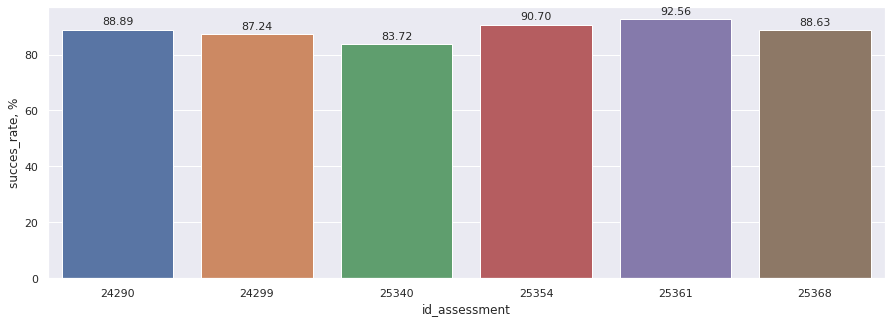

In [37]:
plt.figure(figsize=(15, 5))
sns.set_theme()
plots = sns.barplot(data=df_2, x='id_assessment', y='succes_rate, %')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                         (bar.get_x() + bar.get_width() / 2, 
                          bar.get_height()), ha='center', va='center', 
                   size=11, xytext=(0, 8), textcoords='offset points')

In [38]:
assessments.query("id_assessment == 25340 or id_assessment == 25361")

,code_module,code_presentation,id_assessment,assessment_type,date,module_presentation_length
87,DDD,2013B,25340,Exam,240.0,240
101,DDD,2014B,25361,Exam,241.0,241


Самый сложный экзамен был по курсу DDD в семестре 2013B с id 25340, процент его сдачи сдачи самый низкий среди всех экзаменов (83.721 %).

Самый легкий экзамен по курсу DDD в семестре 2014B с id 25361, процент его сдачи самый высокий среди всех экзаменов (92.557 %).

### Задание 3
По каждому предмету определи средний срок сдачи экзаменов.

In [39]:
df_3 = studentAssessment.merge(assessments, how='inner', on='id_assessment') \
    .query("score >= 40 & assessment_type == 'Exam'") \
    .groupby('code_module', as_index=False).agg({'date_submitted': 'mean'}) \
    .sort_values('date_submitted').reset_index(drop=True) \
    .rename(columns={'date_submitted': 'avg_exam_date'})
df_3.avg_exam_date = df_3.avg_exam_date.round()
df_3

,code_module,avg_exam_date
0,DDD,238.0
1,CCC,239.0


Студенты сдавали экзамен всего по двум предметам, средний срок сдачи этих экзаменов примерно одинаковый, у DDD - на один день меньше.

### Задание 4
Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

Чтобы посчитать отток уберем NaN из date_unregistration

In [40]:
df_4_1 = studentRegistration.query("date_unregistration.notna()")\
    .groupby('code_module', as_index=False).agg(unreg_count=('date_unregistration', 'count')) \
    .sort_values('unreg_count', ascending=False).reset_index(drop=True) \
    .head(3)
df_4_1

,code_module,unreg_count
0,FFF,2380
1,BBB,2377
2,DDD,2235


Под количеством регистраций я понимаю колонку date_registration в studentRegistration, при этом не имеет значения, была ли в дальнейшем отменена регистрация студента или нет.

In [41]:
df_4_2 = studentRegistration.groupby('code_module', as_index=False).agg({'date_registration': 'count'}) \
    .sort_values('date_registration', ascending=False).reset_index(drop=True) \
    .rename(columns={'date_registration': 'reg_count'}) \
    .head(3)
df_4_2

,code_module,reg_count
0,BBB,7900
1,FFF,7751
2,DDD,6257


В тройке лидеров в обоих случаях курсы BBB, DDD, FFF. На них записывается больше всего студентов и больше всего их незавершает.

In [42]:
df_4 = df_4_1.merge(df_4_2, how='inner', on='code_module')
df_4['complete_rate, %'] = (df_4.unreg_count / df_4.reg_count * 100).round(3)
df_4

,code_module,unreg_count,reg_count,"complete_rate, %"
0,FFF,2380,7751,30.706
1,BBB,2377,7900,30.089
2,DDD,2235,6257,35.720


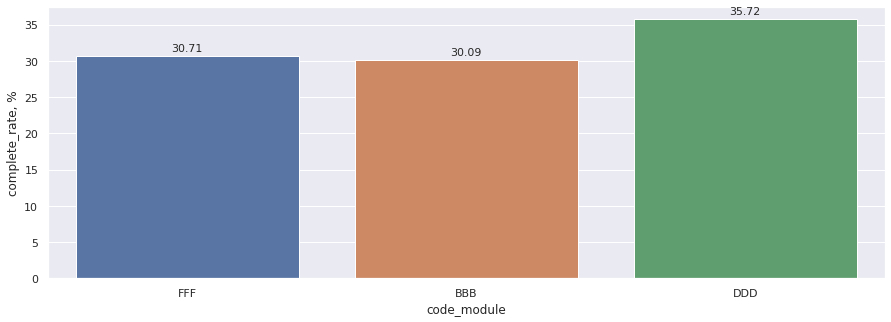

In [43]:
plt.figure(figsize=(15, 5))
sns.set_theme()
plots = sns.barplot(data=df_4, x='code_module', y='complete_rate, %')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                         (bar.get_x() + bar.get_width() / 2, 
                          bar.get_height()), ha='center', va='center', 
                   size=11, xytext=(0, 8), textcoords='offset points')

Лишь треть студентов по этим предметам оканчивают курс.

### Задание 5
Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [44]:
suc_stud = df_1.query("assessment_type == 'Exam' & score > 40") \
    .groupby('code_presentation', as_index=False)\
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'succsess_trying'})

try_stud = df_1.query("assessment_type == 'Exam'") \
    .groupby('code_presentation', as_index=False)\
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'all_trying'})

df_5_1 = suc_stud.merge(try_stud, on='code_presentation')
df_5_1['complete_rate, %'] = (df_5_1.succsess_trying / df_5_1.all_trying * 100).round(3)
df_5_1

,code_presentation,succsess_trying,all_trying,"complete_rate, %"
0,2013B,478,602,79.402
1,2013J,856,968,88.430
2,2014B,1128,1271,88.749
3,2014J,1820,2118,85.930


In [45]:
df_5_2 = df_1.query("assessment_type == 'Exam' and score >= 40")\
    .groupby('code_presentation', as_index=False).agg({'date_submitted': 'mean'})\
    .rename(columns={'date_submitted': 'avg_exam_date'}) \
    .round()
df_5 = df_5_1.merge(df_5_2, on='code_presentation') \
    .sort_values(['complete_rate, %', 'avg_exam_date'], ascending=[True, False])

df_5

,code_presentation,succsess_trying,all_trying,"complete_rate, %",avg_exam_date
0,2013B,478,602,79.402,230.0
3,2014J,1820,2118,85.930,244.0
1,2013J,856,968,88.430,240.0
2,2014B,1128,1271,88.749,233.0


Таким образом, семестром с самой низкой завершаемостью курсов **и** самыми долгими средними сроками сдачи курсов в период с начала 2013 по конец 2014 является семестр **2013B**.

Если же рассматривать два требования по-отдельности, то семестр с самой низкой завершаемостью курсов по-прежнему **2013B**,
а семестр с самым долгим средним сроком сдачи курсов - **2014J**.

### Задание 6

Часто для качественного анализа аудитории используют подходы, основанные на сегментации. 

Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации можешь выбрать следующие метрики: 
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен. 

Подробно опиши, как ты создавал кластеры. 

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Cреднее время сдачи одного экзамена (R):

In [46]:
df_R = df_1.groupby('id_student', as_index=False).agg(R=('date_submitted', 'mean'))
df_R['R'] = df_R['R'].round()
df_R.head()

,id_student,R
0,6516,112.0
1,8462,23.0
2,11391,112.0
3,23629,56.0
4,23698,133.0


Завершаемость курсов (F):

In [47]:
sucсess_stud = df_1.query("assessment_type == 'Exam' & score > 40") \
    .groupby('id_student', as_index=False)\
    .agg({'score': 'count'}) \
    .rename(columns={'score': 'succsess_trying'})

trying_stud = df_1.query("assessment_type == 'Exam'") \
    .groupby('id_student', as_index=False)\
    .agg({'score': 'count'}) \
    .rename(columns={'score': 'all_trying'})

df_F = sucсess_stud.merge(trying_stud, on='id_student')
df_F['F'] = (df_F.succsess_trying / df_F.all_trying * 100).round(3)
df_F = df_F.drop(columns=['succsess_trying', 'all_trying'])
df_F.head()

,id_student,F
0,23698,100.0
1,24213,100.0
2,27116,100.0
3,28787,100.0
4,29411,100.0


Cреднее количество баллов для каждого студента, получаемое за экзамен (M):

In [48]:
df_M = df_1.groupby('id_student', as_index=False).agg(M=('score', 'mean'))
df_M['M'] = df_M['M'].round()
df_M.head()

,id_student,M
0,6516,62.0
1,8462,87.0
2,11391,82.0
3,23629,82.0
4,23698,74.0


#### Общий *df* с результатами студентов:

In [49]:
RFM = (df_R.merge(df_F, on='id_student')).merge(df_M, on='id_student')
RFM.head()

,id_student,R,F,M
0,23698,133.0,100.0,74.0
1,24213,126.0,100.0,76.0
2,27116,133.0,100.0,93.0
3,28787,140.0,100.0,54.0
4,29411,108.0,100.0,59.0


In [50]:
RFM.describe()

,id_student,R,F,M
count,3.994000e+03,3994.000000,3994.000000,3994.000000
mean,7.373102e+05,121.767651,99.586880,76.907862
std,5.834512e+05,12.628229,4.526637,12.501140
min,2.369800e+04,33.000000,50.000000,35.000000
25%,5.059280e+05,116.000000,100.000000,69.000000
50%,5.922810e+05,122.000000,100.000000,78.000000
75%,6.488508e+05,129.000000,100.000000,87.000000
max,2.698251e+06,241.000000,100.000000,100.000000


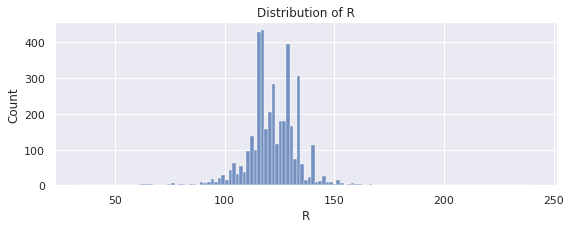

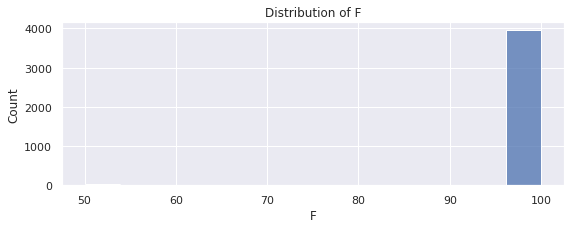

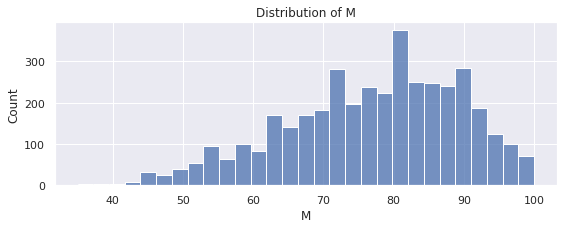

In [51]:
colnames = ['R', 'F', 'M']
for col in colnames:
    fig, ax = plt.subplots(figsize=(9, 3))
    sns.histplot(RFM[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

Значения по R (среднее время сдачи одного экзамена) разделим по квартилям, где медиана соответствует 50-му перцентилю.
Нужные нам значения уже есть в методе .describe выше.

Далее названия студентам я буду давать в соответствии с едой, её температурой и графиками приёма пищи. Мне этот вариант кажется подходящим по смыслу и смешным)))

Среднее время сдачи экзамена будет по аналогии с графиками приёма пищи.
Получили студентов, которые сдают экзамены (кушают) на:

- **(1) завтрак**, 0 - 116 дней, 
- **(2) полдник**, 116 - 122 дня, 
- **(3) обед**, 122 - 129 дней.
- **(4) ужин**, 129 - 241 день.


Посмотрим на значения по F:

In [52]:
RFM['F'].value_counts()

100.0    3961
50.0       33
Name: F, dtype: int64

Так как по F (завершаемость курсов) у нас всего два уникальных значения - 50% и 100%, можем условно разделить студентов 

на студентов с:
- **(1) горячей** едой (100% завершаемость курсов)
- **(2) остывшей** едой (50% завершаемость курсов)

В дальнейшем реализуем это через if-else в лямба-функции.

Теперь посмотрим на значения M:

Для удобства в этом задании округлили среднюю оценку за экзамен до целого значения.

По M (среднее количество баллов за экзамен) можем сегментировать студентов по аналогии с пятибальной системой оценивания.

Получим студентов, которые едят такие блюда, как:

- **(1) яичница** (100 баллов)
- **(2) овсяная каша** (80 - 99 баллов)
- **(3) борщ** (60 - 79 баллов)
- **(4) стейк** (40 - 59 баллов)
- **(5) кастрюля ничего** (меньше 40), в данном случае это тот, кто не сдал экзамен

Такое деление не будем реализовывать через квантили, т.к. рискуем потерять разницу в важных значениях оценок - стейк и кастрюля ничего смешаются в одну группу, потому что порог например 25 перцентиля - 69 баллов (высокий). 

Чтобы различать эти две категории, пришлось бы подбирать перцентиль, получили бы 11й и 0.11й. Но зачем нам идти таким сложным путем? 

Поэтому мной было принято решение сделать сегментирование по M через if-else - в таком случае кусок кода будет выглядеть понятнее.

In [53]:
# RFM['M'].quantile([0.0011, 0.11, 0.55, 1.0])

Сформируем общий df с рангами:

In [54]:
RFM['R_score'] = pd.qcut(RFM['R'], 4, ['1', '2', '3', '4'])

RFM['F_score'] = RFM['F'].apply(lambda x: 1 if x == 100 else 2)


def monetary(x):
    if x == 100:
        y = 1
    elif 80 <= x < 100:
        y = 2
    elif 60 <= x < 80:
        y = 3
    elif 40 <= x < 60:
        y = 4
    elif x < 40:
        y = 5
    return y


RFM['M_score'] = RFM['M'].apply(monetary)


RFM['total_score'] = RFM.R_score.astype(str) + RFM.F_score.astype(str) + RFM.M_score.astype(str)

RFM.head()

,id_student,R,F,M,R_score,F_score,M_score,total_score
0,23698,133.0,100.0,74.0,4,1,3,413
1,24213,126.0,100.0,76.0,3,1,3,313
2,27116,133.0,100.0,93.0,4,1,2,412
3,28787,140.0,100.0,54.0,4,1,4,414
4,29411,108.0,100.0,59.0,1,1,4,114


Теперь сделаем df c едой)

**Логика тут такая:** лучший студент - он как горячая яичница на завтрак, или овсяная каша на полдник. Вкусно и полезно.

Но будет не очень вкусно, если еда будет остывшей => завершаемость курсов у студента будет низкая.

Борщ на обед - тоже вкусно, но если его есть на завтрак или ужин - не очень логично.

Стейк на ужин - уже вариант не очень хороший, потому что каллорийно и не слишком полезно => студент сдает экзамен поздно и на низкий балл.

Кастрюля с ничем - худшее что может быть, если вы не на диете => студент, заваливший экзамен - что может быть хуже?

In [55]:
def food(x):    
    if int(x[1]) == 1 and (int(x[2]) == 3 or int(x[2]) == 4):
        temp = 'горячий'
    elif int(x[1]) == 1 and (int(x[2]) == 1 or int(x[2]) == 2 or int(x[2]) == 5):
        temp = 'горячая'
    elif int(x[1]) == 2 and (int(x[2]) == 3 or int(x[2]) == 4):
        temp = 'остывший'
    elif int(x[1]) == 2 and (int(x[2]) == 1 or int(x[2]) == 2 or int(x[2]) == 5):
        temp = 'остывшая'

    if int(x[0]) == 1:
        eating = 'завтрак'
    elif int(x[0]) == 2:
        eating = 'полдник'
    elif int(x[0]) == 3:
        eating = 'обед'
    elif int(x[0]) == 4:
        eating = 'ужин'

    if int(x[2]) == 1:
        meal = 'яичница'
    elif int(x[2]) == 2:
        meal = 'овсяная каша'
    elif int(x[2]) == 3:
        meal = 'борщ'
    elif int(x[2]) == 4:
        meal = 'стейк'
    elif int(x[2]) == 5:
        meal = 'кастрюля ничего'
    
    return f'{temp} {meal} на {eating}'


RFM['food'] = RFM['total_score'].apply(food)

In [56]:
cluster = pd.DataFrame(RFM[['total_score', 'food']].value_counts())
cluster = cluster.reset_index().rename(columns={0: 'count'})
cluster

,total_score,food,count
0,113,горячий борщ на завтрак,552
1,112,горячая овсяная каша на завтрак,490
2,412,горячая овсяная каша на ужин,483
3,312,горячая овсяная каша на обед,469
4,212,горячая овсяная каша на полдник,428
5,213,горячий борщ на полдник,417
6,313,горячий борщ на обед,410
7,413,горячий борщ на ужин,295
8,314,горячий стейк на обед,120
9,114,горячий стейк на завтрак,119


Выше представлена таблица с возможными комбинациями параметров.

Получили 26 кластеров.

Анализировать такое большое количество кластеров трудоёмко. 

Далее при анализе не будем учитывать кластеры, которые содержат 10 и менее записей (т.к. это составляет 0.25% от общего числа записей).

Тогда останется 12 кластеров. Названия им менять не будем - они у них уже есть.

In [57]:
adv_cluster = cluster.query('count > 10')
adv_cluster

,total_score,food,count
0,113,горячий борщ на завтрак,552
1,112,горячая овсяная каша на завтрак,490
2,412,горячая овсяная каша на ужин,483
3,312,горячая овсяная каша на обед,469
4,212,горячая овсяная каша на полдник,428
5,213,горячий борщ на полдник,417
6,313,горячий борщ на обед,410
7,413,горячий борщ на ужин,295
8,314,горячий стейк на обед,120
9,114,горячий стейк на завтрак,119


Визуализируем.

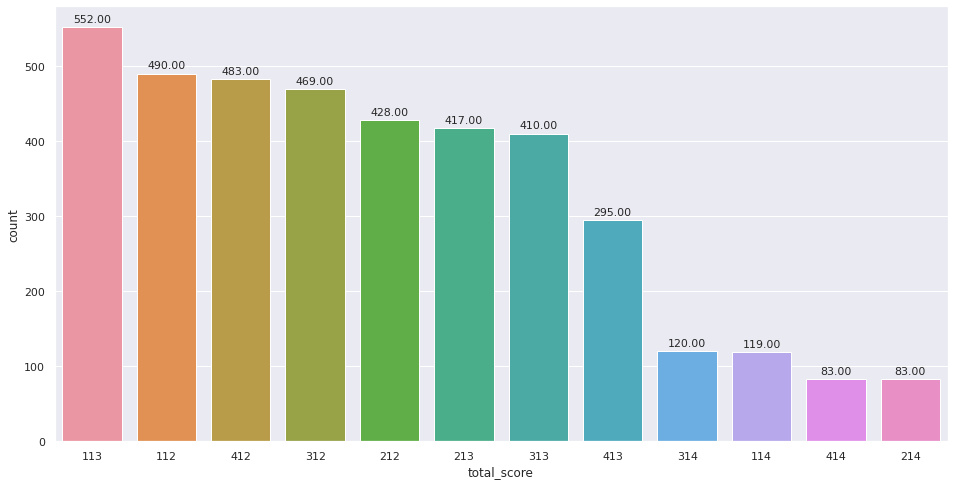

In [58]:
plt.figure(figsize=(16, 8))
sns.set_theme()
plots = sns.barplot(x=adv_cluster['total_score'], y=adv_cluster['count'])
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                         (bar.get_x() + bar.get_width() / 2, 
                          bar.get_height()), ha='center', va='center', 
                   size=11, xytext=(0, 8), textcoords='offset points')

### Выводы

Получили 12 кластеров.

Самый распространенный кластер - **113**. 

- Это студенты, которые предпочитают **горячий борщ на завтрак**. Это... хорошо, потому что горячий и потому что на завтрак. Но было бы гораздо лучше, если бы это была овсяная каша или яичница. То есть, этим студентам можно порекомендовать чуть лучше готовится к экзаменам, чтобы стать идеальными, лучшими их лучших. Они очень близки к этому.

Далее следует кластер **112**.
- Это студенты, которые едят **на завтрак горячую овсяную кашу**. Это самые лучшие студенты среди наших кластеров. То, что по количеству они идут у нас на втором месте - не может нас не радовать. Это значит, что курсы наши понятные, интересные и сдавать их на высокий балл не так уж и сложно. А конкретно эти студенты - ответственные и стараются всё сдать как можно раньше.

Далее - кластер **412**.
- Это студенты, которые едят **на ужин горячую овсяную кашу**. Это тоже хороший вариант. Тоже полезно. Но логинее было бы есть кашу на завтрак. Таким студентам можно в дальнейшем посоветовать не затягивать со сроками сдачи экзаменов. У студентов хорошие оценки, если будут сдавать экзамены пораньше - приблизятся к идеальным студентам.

Кластер **312**.
 - Это студенты, которые едят **на обед горячую овсяную кашу**. Это тоже хорошо. Но на завтрак - лучше. Поэтому, к ним такие же рекомендации, как и к студентам предыдущего кластера.

Далее идет кластер **212**.
 - Эти студенты предпочитают **горячую овсяную кашу в полдник**. Хорошее сочетание, уверенные хорошисты.
 
Следующие кластеры - **213**, **313**, **413**. Это любители **горячего борща** в полдник, обед и ужин соответственно. И, если борщ в обед - это хорошее сочетание, то первому кластеру можно посоветовать есть в полдник что-то более легкое - например, овсяную кашу (получше готовиться к экзаменам), а третьему - не затягивать с употреблением борща и сдавать экзамены пораньше.

Последние 4 кластера - любители **горячих стейков**. Нас несомненно должно радовать, что эту не очень полезную пищу едят не так часто. В сумме эти 4 кластера составляют примерно 11 процентов от количества всех студентов. Возможно, для них стоит организовать дополнительные консультации перед экзаменами, чтобы на экзамене им было проще.

### И еще выводы

Первые 5 перечисленных кластеров - это супер-крутые студенты и они составляют 61% от общего числа студентов. Это высокий показатель, который не может не радовать. Рекомендации, как сделать его ещё выше, были даны конкретно для каждого кластера.

Следующие 3 кластера - это студенты-среднячки. Они составляют 28% от общего числа. Возможно, им не очень важна оценка по предмету, либо они что-то недопоняли в процессе обучения.

Последние 4 кластера - студенты с низкими оценками. Их у нас не так много, 11%. Чтобы сделать этот показатель еще меньше, возможно, следует провести индивидуальную работу с этой группой студентов. Назначить им дополнительные консультации/занятия перед тестированием.